#                              Object detection from captured image on the locations using Mavc2
In this project we are going to have an object detection from captured image on the locations using Mavc2 and I will explain all of the following code 

### 1
In this part I will train a model on FashionMNIST and then later I use it to classifiy the captured image from Quod 

#### 1.1
The following code is for calling some useful package such as numpay, torch and Image then By appending the webots path to sys.path, Python will now search for modules in that directory to import them and finally seed some values to avoide randomness.

* Python Version: 3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:38:07) [MSC v.1929 64 bit (AMD64)]
* NumPy Version: 1.24.4
* OpenCV Version: 4.9.0
* PyTorch Version: 2.2.0
* Torchvision Version: 0.15.2a0
* Matplotlib Version: 3.5.3



In [1]:
import numpy as np,sys,cv2,matplotlib
import random,torch,os,torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image

"""print("Python Version:", sys.version)
print("NumPy Version:", np.__version__)
print("OpenCV Version:", cv2.__version__)
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("Matplotlib Version:", matplotlib.__version__)"""

webots = r'C:\Program Files\Webots\lib\controller\python'
sys.path.append(webots)
from controller import Robot, Keyboard

seed = 1
np.random.seed(seed)
np.random.default_rng(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

c:\ProgramData\anaconda3\envs\Webots\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### 1.2
The fowlling part downlaod the dataset if it doesn't exist in the data folder, to be invarinet from rodation of the captured image I augmented the dataset evey 30 degree and then train and test set is created for training and testing 

Original training set size: 60000
Augmented training set size: 720000


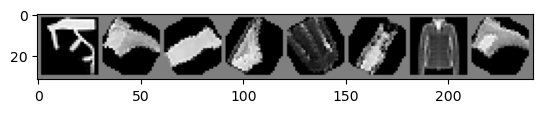

In [2]:
# Define data transformations for preprocessing with normalization
transform = transforms.Compose([
    transforms.ToTensor(),                   # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))     # Normalize the data with mean 0.5 and standard deviation 0.5
])

# Custom dataset class for augmented FashionMNIST
class AugmentedFashionMNIST(Dataset):
    def __init__(self, root, train, transform=None, target_transform=None, download=False):
        self.dataset = datasets.FashionMNIST(root=root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.angles = [30 * i for i in range(1, 12)]  # 30, 60, 90, ..., 330 degrees

    def __len__(self):
        return len(self.dataset) * (len(self.angles) + 1)  # Original + augmented

    def __getitem__(self, idx):
        dataset_length = len(self.dataset)
        original_idx = idx % dataset_length
        angle_idx = idx // dataset_length
        
        image, label = self.dataset[original_idx]
        
        if angle_idx == 0:
            # Return the original image
            return image, label
        else:
            # Rotate the image by the corresponding angle
            angle = self.angles[angle_idx - 1]
            rotated_image = transforms.functional.rotate(image, angle)
            return rotated_image, label

# Load FashionMNIST dataset for training with data augmentation
trainset = AugmentedFashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load FashionMNIST dataset for testing (no augmentation)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders for training and testing
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

# Verify the length of the augmented dataset
print(f"Original training set size: {len(datasets.FashionMNIST(root='./data', train=True))}")
print(f"Augmented training set size: {len(trainset)}")

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Corrected line

# Show images
imshow(torchvision.utils.make_grid(images[:8]))


#### 1.3
in this part I used a MLP as a network that I want to learn to classifiy the images

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        input_size = 28 * 28 
        # Define the fully connected layers and activation functions
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # Define the forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x


#### 1.4
The following part have 4 fanction __init__, __train__, __test1__ and __test2__.
* fisrt one is respainsble to initialize needed partmter such as an instans of MLP,loss and optimizer
* Train function is used to train the MLP to learn how to classifiy the images and if dosen't exist the weights that meant we have to train the model and with loss and optimizer

* Test1 is used to tell au acurassy of the model on the test set
* Test2 is the functon that we give it the prossed image which is chaptured from the Quad and it will return a label for the image


In [4]:

class TrainTest:
    def __init__(self):
    # Uncomment this part if you want to train the network on the dataset and comment def __init__(self):
    #def __init__(self,hyperparams):
        self.model = MLP()

        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.weights_file = 'model_weights.pth'
   
    def train(self):

        # Check if the file with model weights exists
        if os.path.isfile(self.weights_file):
            # Load the model weights if the file exists
            self.model.load_state_dict(torch.load(self.weights_file))
            print('Model weights loaded.')
        else:
            print('No saved weights found. Training the model...')
            num_epochs = 10
            print('#' * 15 + '     Start Training     ' + '#' * 15)
            
            # Training loop
            for epoch in range(num_epochs):
                total_correct_train = 0
                total_samples_train = 0

                # Iterate over batches in the training loader
                for batch in train_loader:
                    images, labels = batch
                    images = images.view(images.size(0), -1)  # Flatten the images
                    outputs = self.model(images)
                    
                    # Compute the loss and perform optimization
                    loss = self.criterion(outputs, labels)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    # Compute training accuracy
                    _, predicted = torch.max(outputs, 1)
                    total_correct_train += (predicted == labels).sum().item()
                    total_samples_train += labels.size(0)

                accuracy_train = total_correct_train / total_samples_train
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {accuracy_train:.4f}')

            print('Training finished.')

            torch.save(self.model.state_dict(), self.weights_file)
            print(f'Model weights saved to {self.weights_file}.')
   
    def test1(self):
        os.path.isfile(self.weights_file)
           # Load the model weights if the file exists
        self.model.load_state_dict(torch.load(self.weights_file))
        print('Model weights loaded.')
        self.model.eval()

        total_correct_test = 0
        total_samples_test = 0

        for batch in test_loader:
            images, labels = batch
            images = images.view(images.size(0), -1)  # Flatten the images
            outputs = self.model(images)

            _, predicted = torch.max(outputs, 1)
            total_correct_test += (predicted == labels).sum().item()
            total_samples_test += labels.size(0)

        accuracy_test = total_correct_test / total_samples_test
        print(f'Test Accuracy: {accuracy_test:.4f}')

    def test2(self,filename):
        
        # Define the path to the image and model weights
        #filename = './Images/image9.jpg'
        
        # Load the model weights if the file exists
        self.model.load_state_dict(torch.load(self.weights_file))
        self.model.eval()
        # Load and preprocess the image
        transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to grayscale if the model expects grayscale images
            transforms.Resize((28, 28)),  # Resize the image to 28x28
            transforms.ToTensor(),  # Convert the image to a tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalize the image (optional)
        ])
        class_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        # Load the image
        image = Image.open(filename)
        image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            # Flatten the image if the model expects a flattened input
            image = image.view(1, -1)  # Flatten the image (1, N) if needed

            # Get the model output
            output = self.model(image)

            # Get the predicted label
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
            predicted_class = class_names[predicted_label]

            print(f'Predicted Label is: {predicted_label}, With mane: {predicted_class}')

# Uncomment this part if you want to train the network on the dataset
#if __name__ == "__main__":
#    hyperparams = {       
#    }
#    Quad=TrainTest(hyperparams)
#    Quad.train()
#    Quad.test1()
    

### 2
in this part we are going to see how the Quad navgate to the locations and capture and prosses the image for the networkr

#### 2.1
This class has 5 functions __init__, __goto__,__land__, __capture_image__, and __imagepro__
* The first one must initialize payper paramters, device form quad and other paramters
* I think goto function is the most imprtant part of this code which control the Ronot to go in the locations and I will explain every line of it with comments 
* land function is used to land the bot in the last location
* Capture image is used to captuer a image after the quad reach to any loaction
* imagepro is used to prosses the taken image for the network to classifiy the it

In [5]:
class quad:
    def __init__(self, robot) -> None:
        self.timestep = timestep = int(robot.getBasicTimeStep())
        self.robot = robot
        self.counter = 0
        self.ka = 5
        self.kb = 0.5
        self.kc = 0.5
        
        # self.p_controller = pc
        self.camera = robot.getDevice("camera")
        self.camera.enable(timestep)
        self.front_left_led = robot.getDevice("front left led")
        self.front_right_led = robot.getDevice("front right led")
        self.imu = robot.getDevice("inertial unit")
        self.imu.enable(timestep)
        self.gps = robot.getDevice("gps")
        self.gps.enable(timestep)
        self.compass = robot.getDevice("compass")
        self.compass.enable(timestep)
        self.gyro = robot.getDevice("gyro")
        self.gyro.enable(timestep)
        self.keyboard = robot.getKeyboard()
        self.keyboard.enable(timestep)
        self.camera_roll_motor = robot.getDevice("camera roll")
        self.camera_pitch_motor = robot.getDevice("camera pitch")
        self.motors = [
        robot.getDevice("front left propeller"),
        robot.getDevice("front right propeller"),
        robot.getDevice("rear left propeller"),
        robot.getDevice("rear right propeller")
        ]
        for m in self.motors: 
            m.setVelocity(1)
            m.setPosition(float('inf'))
            
        while (robot.step(timestep) != -1):
            if robot.getTime() > 1.0:
                break
              
    def goto(self, x_target, y_target, z_target , yaw_target):
        k_vertical_thrust = 68.5
        k_vertical_offset = 0.6
        k_vertical_p = 3.0
        k_roll_p = 50.0
        k_pitch_p = 30.0
        target_altitude = z_target
        count = 0
        total_D = 99999999
        yaw = self.imu.getRollPitchYaw()[2]
        
        while total_D > 0.06 or np.abs(yaw - yaw_target) > 0.01:
            count += 1
            self.robot.step(self.timestep)
            x = self.gps.getValues()[0]
            y = self.gps.getValues()[1]
            z = self.gps.getValues()[2]
            yaw = self.imu.getRollPitchYaw()[2]
            
            dx = x - x_target
            dy = y - y_target
            dz = z - z_target

            #total_D: Euclidean distance to the target.
            total_D = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

            #x_prime, y_prime: Transformed coordinates in the target frame.
            x_prime = dx * np.cos(yaw_target) + dy * np.sin(yaw_target)
            y_prime = - dx * np.sin(yaw_target) + dy * np.cos(yaw_target)
            #yaw_prime: Difference between current and target yaw angles.
            yaw_prime = yaw - yaw_target
            
            phi = np.arctan2(y_prime, x_prime)#phi: Angle to the target in the transformed frame.
            r = np.sqrt(x_prime ** 2 + y_prime ** 2)#r: Distance to the target in the transformed frame.
            alpha = yaw_prime - phi#alpha: Angular error for heading correction.
            
            omega = -self.kb * yaw_prime#omega: Angular velocity for yaw correction.
            phi_dot = omega - self.kc * alpha#phi_dot: Rate of change of angle phi.

            #vx, vy: Desired velocities in the x and y directions.
            vx = r * (-np.sin(alpha) * phi_dot -self.ka * np.cos(alpha))
            vy = r * (-np.cos(alpha) * phi_dot +self.ka * np.sin(alpha))
            
            #bound: Limits the control inputs to within specified bounds.
            def bound(low, high, value):
                return max(low, min(high, value))
            #roll, pitch: Current roll and pitch angles.
            roll = self.imu.getRollPitchYaw()[0]
            pitch = self.imu.getRollPitchYaw()[1]
            #altitude: Current altitude.
            altitude = self.gps.getValues()[2]
            #roll_velocity, pitch_velocity: Roll and pitch rates.
            roll_velocity = self.gyro.getValues()[0]
            pitch_velocity = self.gyro.getValues()[1]

            #roll_disturbance, pitch_disturbance, yaw_disturbance: Additional control adjustments.
            roll_disturbance = 0.0
            pitch_disturbance = 0.0
            yaw_disturbance = 0.0

            yaw_disturbance = 1.3 * bound(-0.5, 0.5, omega)
            pitch_disturbance = (-2.0) * bound(-0.5, 0.5, vx)
            roll_disturbance = 1.0 * bound(-0.5, 0.5, vy)

            #roll_input, pitch_input, yaw_input: Final control inputs for roll, pitch, and yaw.
            roll_input = k_roll_p * max(min(roll, 1.0), -1.0) + roll_velocity + roll_disturbance
            pitch_input = k_pitch_p * max(min(pitch, 1.0), -1.0) + pitch_velocity + pitch_disturbance
            yaw_input = yaw_disturbance
            #clamped_difference_altitude: Clamped difference in altitude.
            clamped_difference_altitude = max(min(target_altitude - altitude + k_vertical_offset, 1.0), -1.0)
            #vertical_input: Vertical control input.
            vertical_input = k_vertical_p * pow(clamped_difference_altitude, 3.0)

            #Motor Inputs: Combine vertical, roll, pitch, and yaw inputs to compute individual motor commands.
            front_left_motor_input = k_vertical_thrust + vertical_input - roll_input + pitch_input - yaw_input
            front_right_motor_input = k_vertical_thrust + vertical_input + roll_input + pitch_input + yaw_input
            rear_left_motor_input = k_vertical_thrust + vertical_input - roll_input - pitch_input + yaw_input
            rear_right_motor_input = k_vertical_thrust + vertical_input + roll_input - pitch_input - yaw_input
            #setVelocity: Commands each motor to the computed velocity.
            
            self.motors[0].setVelocity(front_left_motor_input)
            self.motors[1].setVelocity(-front_right_motor_input)
            self.motors[2].setVelocity(-rear_left_motor_input)
            self.motors[3].setVelocity(rear_right_motor_input)
            
    def land(self):
        x = self.gps.getValues()[0]
        y = self.gps.getValues()[1]
        yaw = self.imu.getRollPitchYaw()[2]
        self.goto(x,y,-0.3,yaw)
        self.motors[0].setVelocity(0)
        self.motors[1].setVelocity(0)
        self.motors[2].setVelocity(0)
        self.motors[3].setVelocity(0)

    def capture_image(self, filename):

        """image = self.camera.getImage()
        image_array = np.frombuffer(image, np.uint8).reshape((self.camera.getHeight(), self.camera.getWidth(), 4))
        pil_image = Image.fromarray(image_array)
        pil_image.save(filename)
        print(f"Image saved as {filename}")"""
        
        image = self.camera.getImage()
        width = self.camera.getWidth()
        height = self.camera.getHeight()
        image_array = np.frombuffer(image, np.uint8).reshape((height, width, 4))  # RGBA image
        image_rgb = Image.fromarray(image_array, 'RGBA').convert('RGB')  # Convert to RGB
        image_rgb.save(filename)
        print(f"Image saved as {filename}")
    
    def imagepro(self,i,filename):
        image = cv2.imread(filename)

        # Convert the image from BGR to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define the HSV range for the orange color
        # Initial guess for orange color range; might need adjustment
        lower_orange = np.array([0, 5, 150])
        upper_orange = np.array([56, 36, 256])

        # Create a mask using the defined range
        mask = cv2.inRange(hsv_image, lower_orange, upper_orange)

        # Apply the mask to the original image
        result = cv2.bitwise_and(image, image, mask=mask)

        # Convert the result to grayscale for contour detection
        gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

        # Find contours on the binary mask
        contours, _ = cv2.findContours(gray_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the region of interest (ROI) from the original image
        cropped_image = image[y:y+h, x:x+w]

        # Resize the cropped image
        resized_image = cv2.resize(cropped_image, (28, 28), interpolation=cv2.INTER_AREA)
        cv2.imwrite(f'./Images/image{i+5}.jpg', resized_image)

### 3
the lowing part of the code is a class with 2 facntion for using all previous functions to go to the locations, captuer a image , prosses it and pass it to the network for classification and them land on the last place 

In [6]:
class Train:
    def __init__(self,hyperparams):
        robot=Robot()
        self.quad=quad(robot)
        self.ObjectD=TrainTest()
        self.loc1 = ((-5, 4, 3.5, 0))
        self.loc2 = ((-3,-2, 3.5, 0))
        self.loc3 = (( 3,-3, 3.5, 0))
        self.loc4 = (( 5, 0, 3.5, 0))
        self.loc5 = (( 2, 5, 3.5, 0))

        self.locations = [self.loc1, self.loc2, self.loc3, self.loc4, self.loc5]

    def train(self):
        i=1
        for location in self.locations:
            filename=f'./Images/image{i}.jpg'
            print("The Quad is going to Location:", location)
            x_target, y_target, z_target, yaw_target = location
            self.quad.goto(x_target, y_target, z_target , yaw_target)
            self.quad.capture_image(filename)
            self.quad.imagepro(i,filename)
            self.ObjectD.test2(filename=f'./Images/image{i+5}.jpg')
            i+=1

        self.quad.land()
        

if __name__ == "__main__":


    hyperparams = {}
    Quad=Train(hyperparams)
    Quad.train()
    

The Quad is going to Location: (-5, 4, 3.5, 0)
Image saved as ./Images/image1.jpg
Predicted Label is: 0, With mane: T-shirt/top
The Quad is going to Location: (-3, -2, 3.5, 0)
Image saved as ./Images/image2.jpg
Predicted Label is: 2, With mane: Pullover
The Quad is going to Location: (3, -3, 3.5, 0)
Image saved as ./Images/image3.jpg
Predicted Label is: 8, With mane: Bag
The Quad is going to Location: (5, 0, 3.5, 0)
Image saved as ./Images/image4.jpg
Predicted Label is: 5, With mane: Sandal
The Quad is going to Location: (2, 5, 3.5, 0)
Image saved as ./Images/image5.jpg
Predicted Label is: 6, With mane: Shirt


: 